In [11]:
from braindecode.datasets import MOABBDataset

In [12]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

In [13]:
from numpy import multiply

from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

C:\Users\xialugui\PycharmProjects\eeg_mi_dl\.venv\lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [14]:
from braindecode.preprocessing import create_windows_from_events

In [15]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [16]:
splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test']  # Session evaluation

In [17]:
import torch

from braindecode.models import ShallowFBCSPNet, EEGNetv4, EEGNetv1
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

model = EEGNetv1(
    n_chans,
    n_classes,
    n_times=n_times,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model = model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
EEGNetv1 (EEGNetv1)                      [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Conv2d (conv_1): 1-2                   [1, 22, 1125, 1]          [1, 16, 1125, 1]          368                       [1, 1]
├─BatchNorm2d (bnorm_1): 1-3             [1, 16, 1125, 1]          [1, 16, 1125, 1]          32                        --
├─Expression (elu_1): 1-4                [1, 16, 1125, 1]          [1, 16, 1125, 1]          --                        --
├─Expression (permute_1): 1-5            [1, 16, 1125, 1]          [1, 1, 16, 1125]          --                        --
├─Dropout (drop_1): 1-6                  [1, 1, 16, 1125]          [1, 1, 16, 1125]          --                        --
├─Conv2d (

C:\Users\xialugui\PycharmProjects\eeg_mi_dl\.venv\lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [18]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# We found these values to be good for the shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 32

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
)
# Model training for the specified number of epochs. `y` is None as it is
# already supplied in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.2847        1.7690       0.2639            0.2639        1.4109  0.0006  1.8697
      2            0.2917        1.7706       0.2812            0.2812        1.3991  0.0006  1.7525
      3            0.2917        1.8276       0.2535            0.2535        1.4019  0.0006  1.7612
      4            0.2917        1.6723       0.2882            0.2882        1.4002  0.0006  1.7352
      5            0.2986        1.8337       0.2674            0.2674        1.4035  0.0006  1.7425
      6            0.3333        1.6705       0.2778            0.2778        1.3909  0.0006  1.8667
      7            0.3368        1.5851       0.2778            0.2778        1.3843  0.0006  1.8279
      8            0.3090        1.5905       0.2812            0.2812        1.3903  0.000

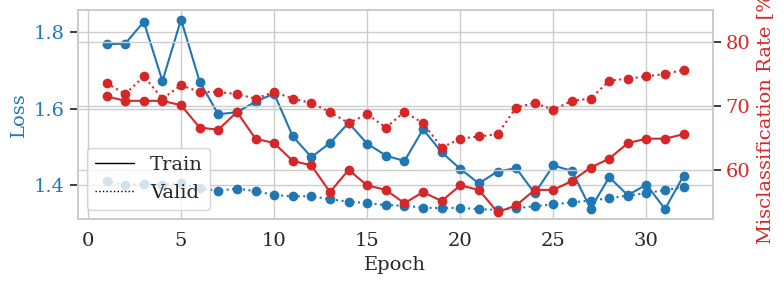

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_accuracy", "valid_accuracy"]
df = pd.DataFrame(
    clf.history[:, results_columns],
    columns=results_columns,
    index=clf.history[:, "epoch"],
)

# get percent of misclass for better visual comparison to loss
df = df.assign(
    train_misclass=100 - 100 * df.train_accuracy,
    valid_misclass=100 - 100 * df.valid_accuracy,
)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ["train_loss", "valid_loss"]].plot(
    ax=ax1, style=["-", ":"], marker="o", color="tab:blue", legend=False, fontsize=14
)

ax1.tick_params(axis="y", labelcolor="tab:blue", labelsize=14)
ax1.set_ylabel("Loss", color="tab:blue", fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ["train_misclass", "valid_misclass"]].plot(
    ax=ax2, style=["-", ":"], marker="o", color="tab:red", legend=False
)
ax2.tick_params(axis="y", labelcolor="tab:red", labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color="tab:red", fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle="-", label="Train")
)
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle=":", label="Valid")
)
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

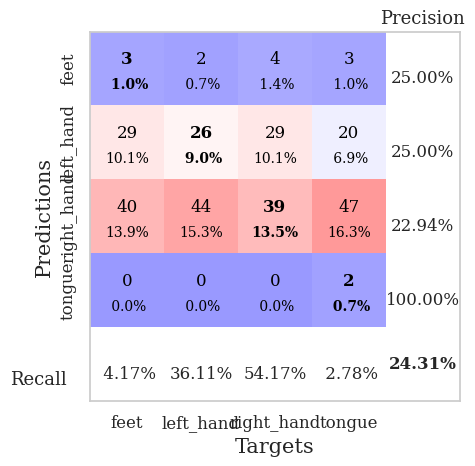

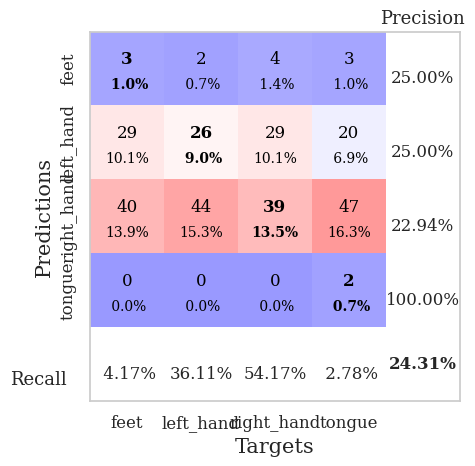

In [20]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]["mapping"]
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)